In [10]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T

from upsample_anything import UPA
from utils import visualize_pca_one
from PIL import Image
    
device = "cuda" if torch.cuda.is_available() else "cpu"

def dinov2_infer(img):
    dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device).eval()

    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])
    img_t = transform(img).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=False):
            feats_list = dinov2_vits14.get_intermediate_layers(img_t, n=1)
            feats_all = feats_list[0].squeeze(0)

    H=W=int(feats_all.shape[0]**0.5)
    feat_map=feats_all.reshape(H,W,-1).permute(2,0,1).unsqueeze(0)

    return feat_map


if __name__ == "__main__":
    img_path = "2009_003810.jpg"
    img = Image.open(img_path).convert("RGB").resize((448, 448), Image.BICUBIC)

    prob = np.load("2009_003810_predlow_probs.npy")
    lr_prob = torch.from_numpy(prob).unsqueeze(0).cuda()
    hr_prob = UPA(img, lr_prob) # 1, 21, 448 448


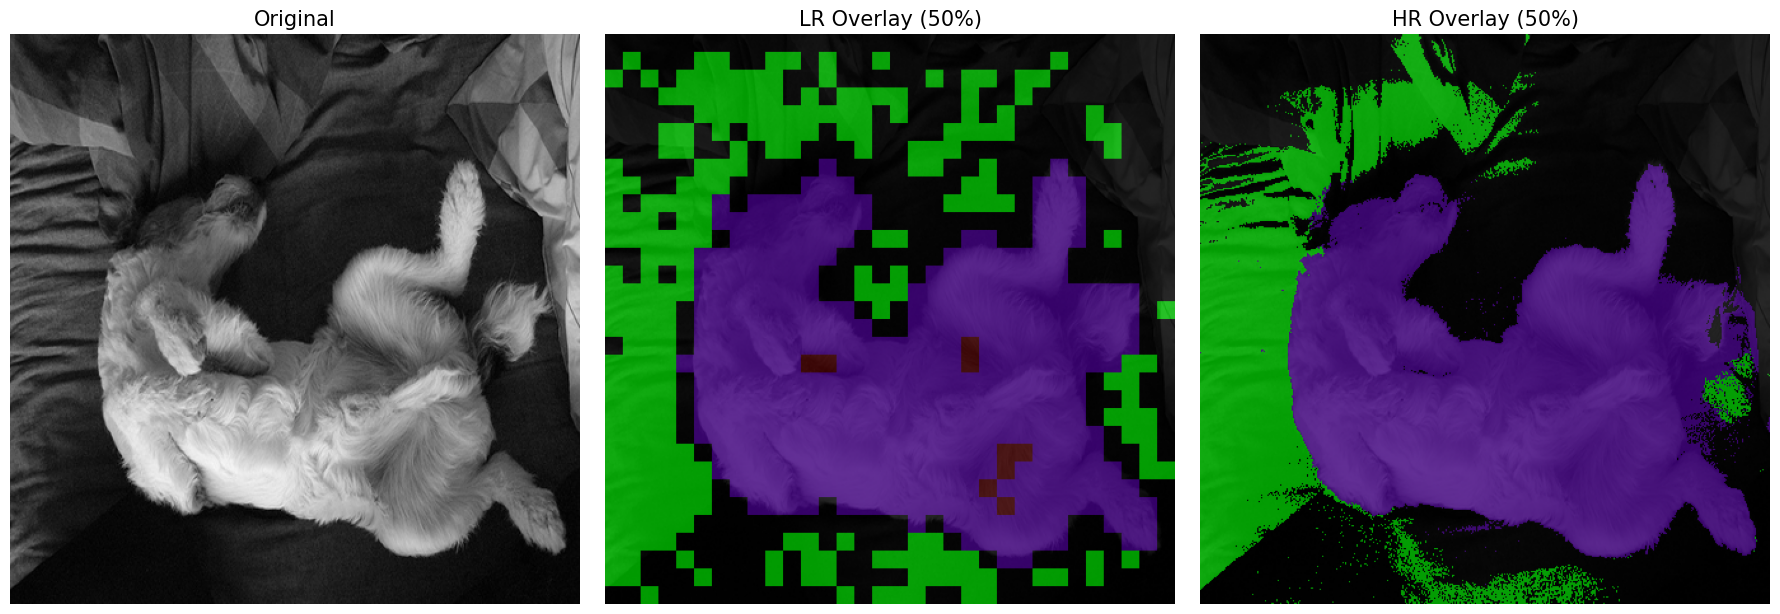

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F


def voc_colormap(N=256):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)
    cmap = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r |= (bitget(c, 0) << (7 - j))
            g |= (bitget(c, 1) << (7 - j))
            b |= (bitget(c, 2) << (7 - j))
            c >>= 3
        cmap[i] = [r, g, b]
    return cmap

palette = voc_colormap(21)


def prob_to_color(prob_3d):
    seg = np.argmax(prob_3d, axis=0)         # (H,W)
    color = palette[seg]                     # (H,W,3)
    return color



def overlay(img_np, seg_color, alpha=0.5):
    return (img_np * (1-alpha) + seg_color * alpha).astype(np.uint8)


def visualize_overlay(img, lr_prob, hr_prob):
    """
    img: PIL image (448×448)
    lr_prob: (1, 21, h, w)
    hr_prob: (1, 21, 448, 448)
    """

    img_np = np.array(img)

    lr_np = lr_prob.squeeze(0).detach().cpu().numpy()     # (21,h,w)
    lr_color = prob_to_color(lr_np)                       # (h,w,3)

    lr_color_up = Image.fromarray(lr_color).resize((448, 448), Image.NEAREST)
    lr_color_up = np.array(lr_color_up)                   # (448,448,3)

    lr_overlay = overlay(img_np, lr_color_up, alpha=0.8)

    hr_np = hr_prob.squeeze(0).detach().cpu().numpy()     # (21,448,448)
    hr_color = prob_to_color(hr_np)                       # (448,448,3)

    hr_overlay = overlay(img_np, hr_color, alpha=0.8)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original", fontsize=15)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(lr_overlay)
    plt.title("LR Overlay (50%)", fontsize=15)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(hr_overlay)
    plt.title("HR Overlay (50%)", fontsize=15)
    plt.axis("off")

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    img_path = "2009_003810.jpg"
    img = Image.open(img_path).convert("RGB").resize((448, 448), Image.BICUBIC)

    prob = np.load("2009_003810_predlow_probs.npy")      # (21,32,32)
    lr_prob = torch.from_numpy(prob).unsqueeze(0).cuda()  # (1,21,32,32)

    hr_prob = UPA(img, lr_prob)  # (1,21,448,448)

    visualize_overlay(img, lr_prob, hr_prob)
